In [ ]:
! pip install pyspark

In [ ]:
! pip install numpy


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import logging

In [2]:
spark = SparkSession.builder \
    .appName("DataCo - Prédiction Retards") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()


In [ ]:
# choisir les colonnes qui nous interesse 
COLUMNS_TO_KEEP = [
    # Variable cible
    'Late_delivery_risk',
    
    # Features numériques importantes
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Benefit per order',
    'Sales per customer',
    'Order Item Quantity',
    'Order Item Discount Rate',
    'Order Item Product Price',
    'Sales',
    'Order Item Total'
    
    # Features catégorielles importantes
    'Shipping Mode',
    'Category Name',
    'Customer Segment',
    'Market',
    'Order Region',
    'Delivery Status',
    'Order Status',
    
    # ID pour déduplication
    'Order Id'
]

In [ ]:
# choisir les colonnes qui nous interesse 
COLUMNS_TO_KEEP = [
    # Variable cible
    'Late_delivery_risk',
    
    # Features numériques importantes
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Benefit per order',
    'Sales per customer',
    'Order Item Quantity',
    'Order Item Discount Rate',
    'Order Item Product Price',
    'Sales',
    'Order Item Total'
    
    # Features catégorielles importantes
    'Shipping Mode',
    'Category Name',
    'Customer Segment',
    'Market',
    'Order Region',
    'Delivery Status',
    'Order Status',
    
    # ID pour déduplication
    'Order Id'
]

In [31]:
df = spark.read.csv("../data/DataCoSupplyChainDataset.csv" , header=True , inferSchema=True ).select(COLUMNS_TO_KEEP)
# inferSchema=True est utilisée lors du chargement d’un fichier (CSV, JSON, Parquet...) pour demander à Spark de deviner automatiquement le type de chaque colonne (entier, double, string, date, etc.) au lieu de tout charger en texte (string).

In [53]:
df.limit(3).show()


+------------------+------------------------+-----------------------------+-----------------+------------------+-------------------+------------------------+------------------------+------+----------------+----------------------+--------------+--------------+----------------+------------+--------------+----------------+------------+--------+
|Late_delivery_risk|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Order Item Quantity|Order Item Discount Rate|Order Item Product Price| Sales|Order Item Total|Order Profit Per Order| Shipping Mode| Category Name|Customer Segment|      Market|  Order Region| Delivery Status|Order Status|Order Id|
+------------------+------------------------+-----------------------------+-----------------+------------------+-------------------+------------------------+------------------------+------+----------------+----------------------+--------------+--------------+----------------+------------+--------------+--------

In [ ]:
df.count()
df_clean = df.dropDuplicates()



In [33]:
df_clean.count()

180519

In [28]:
df_clean = df.dropna(subset=['Late_delivery_risk', 'Days for shipping (real)', 'Shipping Mode']) 
# on supprime les lignes ou les date de livraison ainsi que mode de livraison est null , car c 'est ca qu on veut 
# controller

In [29]:
df_clean.cache()  # On demande à Spark de mettre le DataFrame en cache pour le réutiliser plus tard
df_clean.count()  # Le cache nécessite une action pour s'activer ; count() déclenche le calcul et remplit le cache


180519

In [38]:
# Variables numériques à analyser
NUMERIC_COLS = [
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Benefit per order',
    'Sales per customer',
    'Order Item Quantity',
    'Order Item Discount Rate',
    'Order Item Product Price',
    'Sales',
    'Order Item Total'
]

In [39]:
df_clean.select(NUMERIC_COLS).describe().show()

+-------+------------------------+-----------------------------+------------------+------------------+-------------------+------------------------+------------------------+------------------+------------------+
|summary|Days for shipping (real)|Days for shipment (scheduled)| Benefit per order|Sales per customer|Order Item Quantity|Order Item Discount Rate|Order Item Product Price|             Sales|  Order Item Total|
+-------+------------------------+-----------------------------+------------------+------------------+-------------------+------------------------+------------------------+------------------+------------------+
|  count|                  180519|                       180519|            180519|            180519|             180519|                  180519|                  180519|            180519|            180519|
|   mean|      3.4976539865609713|            2.931846509231715|21.974988638594173|183.10760850778757|  2.127637533999191|     0.10166819055202476|      141

In [ ]:
! pip install seaborn

                               Days for shipping (real)  \
Days for shipping (real)                       1.000000   
Days for shipment (scheduled)                  0.515880   
Sales per customer                             0.001757   
Order Item Quantity                           -0.000811   
Order Item Discount Rate                       0.001467   
Order Item Product Price                       0.002185   
Sales                                          0.001962   
Order Item Total                               0.001757   

                               Days for shipment (scheduled)  \
Days for shipping (real)                            0.515880   
Days for shipment (scheduled)                       1.000000   
Sales per customer                                  0.006445   
Order Item Quantity                                -0.002925   
Order Item Discount Rate                            0.000065   
Order Item Product Price                            0.006912   
Sales               

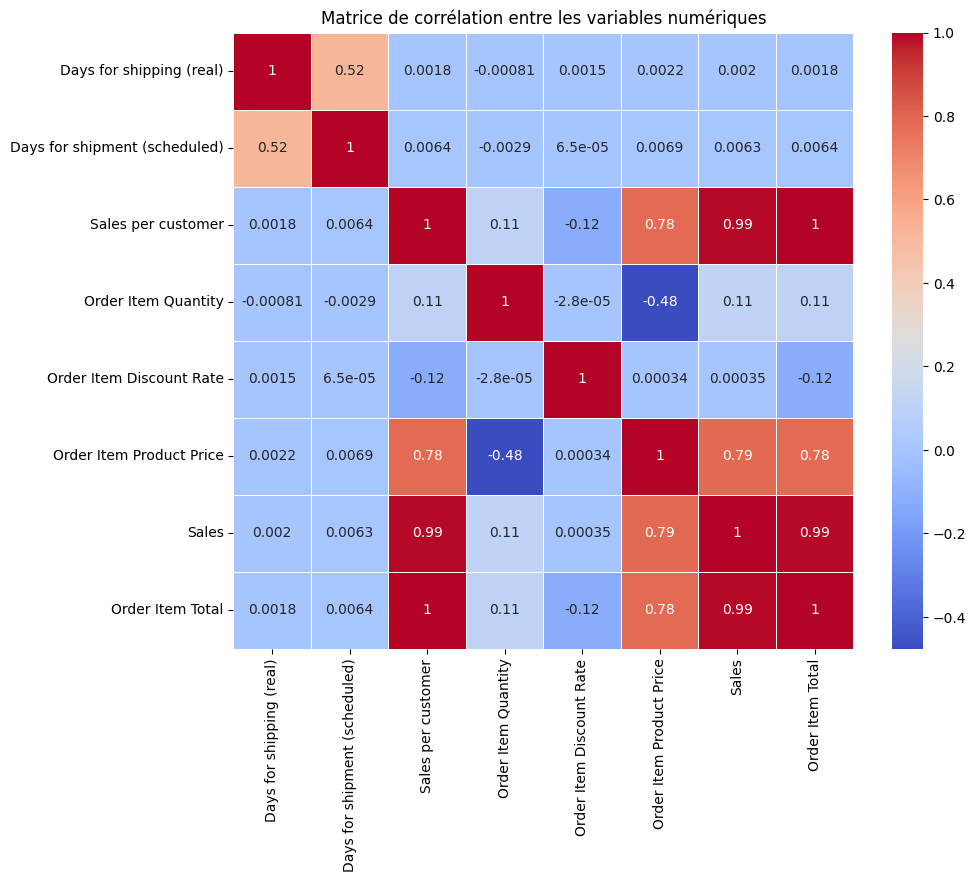

In [56]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des colonnes numériques
numeric_df = df.select([col(c).cast("double") for c in NUMERIC_COLS])

# Conversion en pandas pour calculer la matrice de corrélation
pandas_df = numeric_df.toPandas()

# Calcul de la matrice de corrélation
corr_matrix = pandas_df.corr()

# Affichage sous forme de tableau
print(corr_matrix)

# Visualisation graphique (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation entre les variables numériques")
plt.show()


In [ ]:
from pyspark.sql.functions import corr
# alors on le supprime des col NUMERIC_COLS dont il y a trop de correlation
NUMERIC_COLS.remove('Benefit per order')
NUMERIC_COLS.remove('Order Item Total') 
NUMERIC_COLS.remove('Sales per customer') 
NUMERIC_COLS.remove('Order Item Product Price') 

                               Days for shipping (real)  \
Days for shipping (real)                       1.000000   
Days for shipment (scheduled)                  0.515880   
Order Item Quantity                           -0.000811   
Order Item Discount Rate                       0.001467   
Sales                                          0.001962   

                               Days for shipment (scheduled)  \
Days for shipping (real)                            0.515880   
Days for shipment (scheduled)                       1.000000   
Order Item Quantity                                -0.002925   
Order Item Discount Rate                            0.000065   
Sales                                               0.006327   

                               Order Item Quantity  Order Item Discount Rate  \
Days for shipping (real)                 -0.000811                  0.001467   
Days for shipment (scheduled)            -0.002925                  0.000065   
Order Item Quantity 

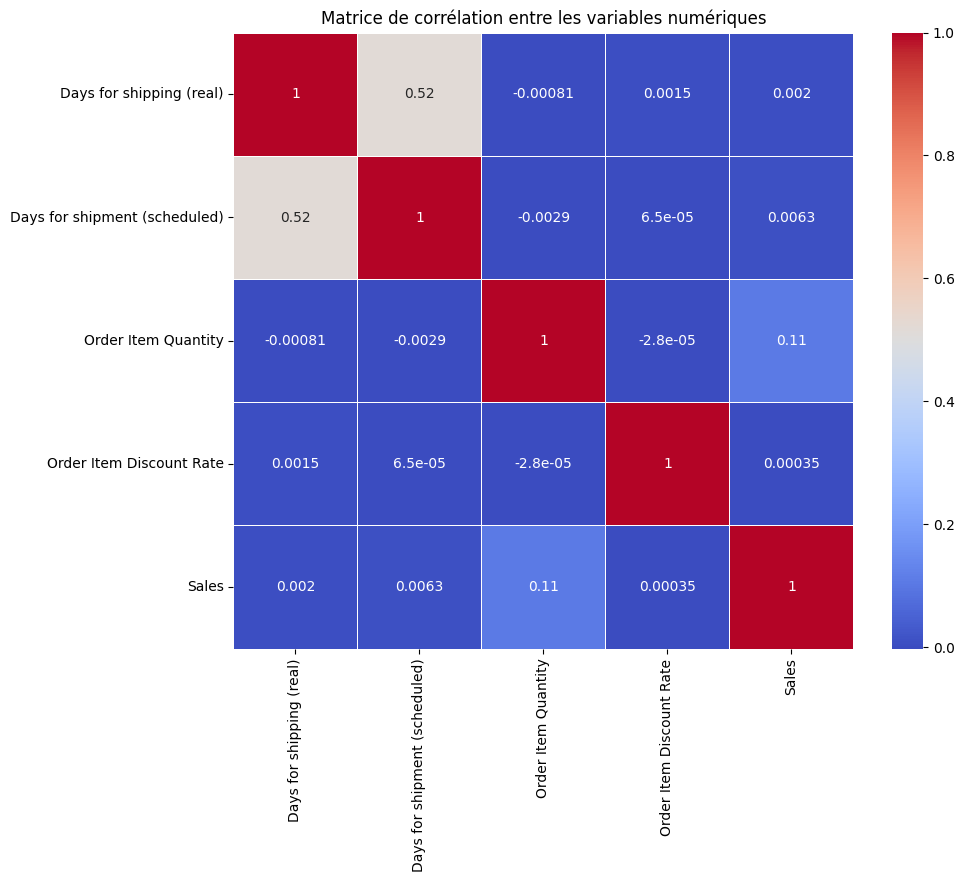

In [65]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des colonnes numériques
numeric_df = df.select([col(c).cast("double") for c in NUMERIC_COLS])

# Conversion en pandas pour calculer la matrice de corrélation
pandas_df = numeric_df.toPandas()

# Calcul de la matrice de corrélation
corr_matrix = pandas_df.corr()

# Affichage sous forme de tableau
print(corr_matrix)

# Visualisation graphique (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation entre les variables numériques")
plt.show()


In [ ]:
! pip install matplotlib

In [66]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

def calculate_iqr_bounds(df, col_name):
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound, Q1, Q3, IQR

outliers_info = {}

for col_name in NUMERIC_COLS:
    lower, upper, Q1, Q3, IQR = calculate_iqr_bounds(df, col_name)
    
    outliers_count = df.filter(
        (col(col_name) < lower) | (col(col_name) > upper)
    ).count()
    
    total = df.count()
    outliers_pct = (outliers_count / total) * 100

    outliers_info[col_name] = {
        'lower': lower, 'upper': upper,
        'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
        'count': outliers_count, 'pct': outliers_pct
    }

    print(f"\n📊 {col_name}")
    print(f"   Q1={Q1:.2f} | Q3={Q3:.2f} | IQR={IQR:.2f}")
    print(f"   Bornes: [{lower:.2f}, {upper:.2f}]")
    print(f"   Outliers: {outliers_count} ({outliers_pct:.2f}%)")





📊 Days for shipping (real)
   Q1=2.00 | Q3=5.00 | IQR=3.00
   Bornes: [-2.50, 9.50]
   Outliers: 0 (0.00%)

📊 Days for shipment (scheduled)
   Q1=2.00 | Q3=4.00 | IQR=2.00
   Bornes: [-1.00, 7.00]
   Outliers: 0 (0.00%)

📊 Order Item Quantity
   Q1=1.00 | Q3=3.00 | IQR=2.00
   Bornes: [-2.00, 6.00]
   Outliers: 0 (0.00%)

📊 Order Item Discount Rate
   Q1=0.04 | Q3=0.16 | IQR=0.12
   Bornes: [-0.14, 0.34]
   Outliers: 0 (0.00%)

📊 Sales
   Q1=119.98 | Q3=299.95 | IQR=179.97
   Bornes: [-149.98, 569.91]
   Outliers: 488 (0.27%)


In [ ]:
! pip install -U pandas


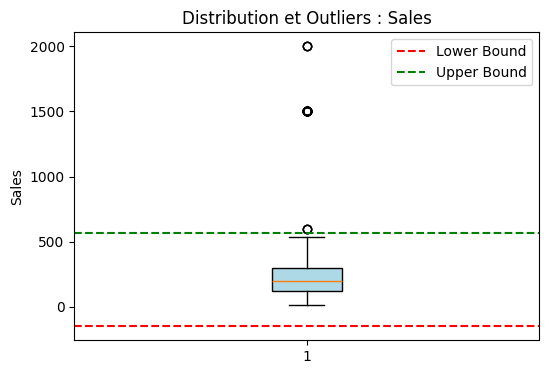

In [69]:
# ========= VISUALISATION GRAPHIQUE =========
df_sample = df.select(NUMERIC_COLS).sample(False, 0.1, seed=42).toPandas()
dic_outliers=[]
for col_name in NUMERIC_COLS:
    lower, upper, Q1, Q3, IQR = calculate_iqr_bounds(df, col_name)
    outliers_count = df.filter((col(col_name) < lower) | (col(col_name) > upper)).count()
    if  outliers_count > 0 : 
        plt.figure(figsize=(6, 4))
        plt.boxplot(df_sample[col_name].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        plt.axhline(y=lower, color='red', linestyle='--', label='Lower Bound')
        plt.axhline(y=upper, color='green', linestyle='--', label='Upper Bound')
        plt.title(f'Distribution et Outliers : {col_name}')
        plt.ylabel(col_name)
        plt.legend()
        plt.show()
        lst = {"col_name":col_name , "lower_bound":lower , "upper_bound":upper}
        dic_outliers.append(lst)

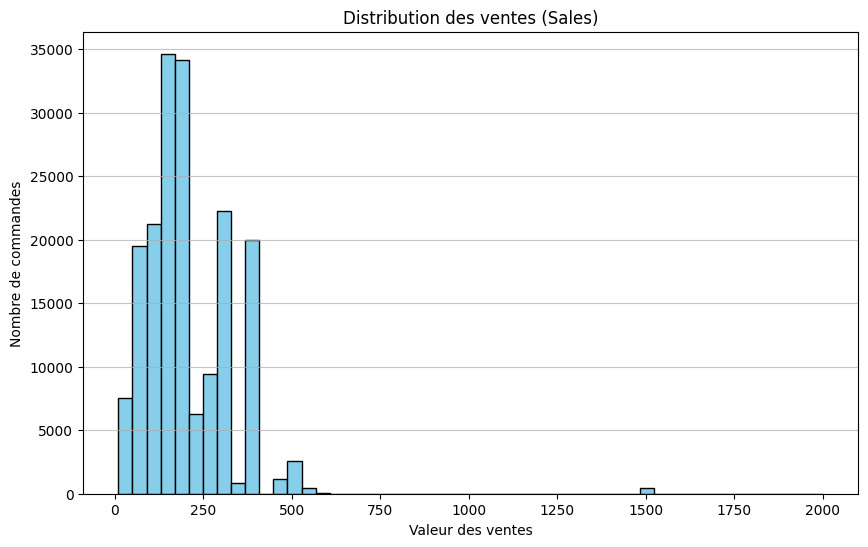

In [67]:
import matplotlib.pyplot as plt

# 1️⃣ Convertir en Pandas pour la visualisation
sales_pd = df_clean.select("Sales").toPandas()

# 2️⃣ Créer l'histogramme
plt.figure(figsize=(10,6))
plt.hist(sales_pd["Sales"], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution des ventes (Sales)")
plt.xlabel("Valeur des ventes")
plt.ylabel("Nombre de commandes")
plt.grid(axis='y', alpha=0.75)
plt.show()


In [70]:
# on supprime les outliers de sales 
from pyspark.sql.functions import col

# Commencer avec le df original nettoyé
df_no_outliers = df_clean

# Parcourir le dictionnaire pour filtrer chaque colonne
for outlier_info in dic_outliers:
    col_name = outlier_info["col_name"]
    lower = outlier_info["lower_bound"]
    upper = outlier_info["upper_bound"]
    
    df_no_outliers = df_no_outliers.filter(
        (col(col_name) >= lower) & (col(col_name) <= upper)
    )

print(f"Lignes après suppression des outliers : {df_no_outliers.count()}")


Lignes après suppression des outliers : 180031
